In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
import os

sys.path.append(os.path.join(os.path.abspath('.'),'../../plankton'))

In [2]:
import plankton as pl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
data_folder='data/'

dpum=0.335

coordinates = pd.read_csv(os.path.join(data_folder,'./coordinates.csv'))
signatures = pd.read_csv(os.path.join(data_folder,'./signatures_original.csv'),index_col=0)

# dapi_image = plt.imread(os.path.join(data_folder,'pancreas_bg.jpg')).mean(-1).T
dapi_image = plt.imread(os.path.join(data_folder,'AFHES365-H1-small.tif')).astype(float)

dapi_image/=dapi_image.max()
dapi_image=1-dapi_image

bg = pl.PixelMap(dapi_image.T,upscale=0.25/dpum,x_shift=0*dpum,y_shift=0*dpum)
# bg = pl.PixelMap(dapi_image.T,upscale=0.0192/dpum,x_shift=800*dpum,y_shift=800*dpum)

In [4]:
sdata = pl.SpatialData(coordinates.gene, 
                       coordinates.Y*dpum, 
                       coordinates.X*dpum,
                       pixel_maps=[bg])[::5]

In [53]:
len(sdata.stats)

138

In [54]:

sdata.obsc["celltype"] = signatures.index[np.array(signatures).argmax(0)]
sdata.obsc.assign_colors('celltype')

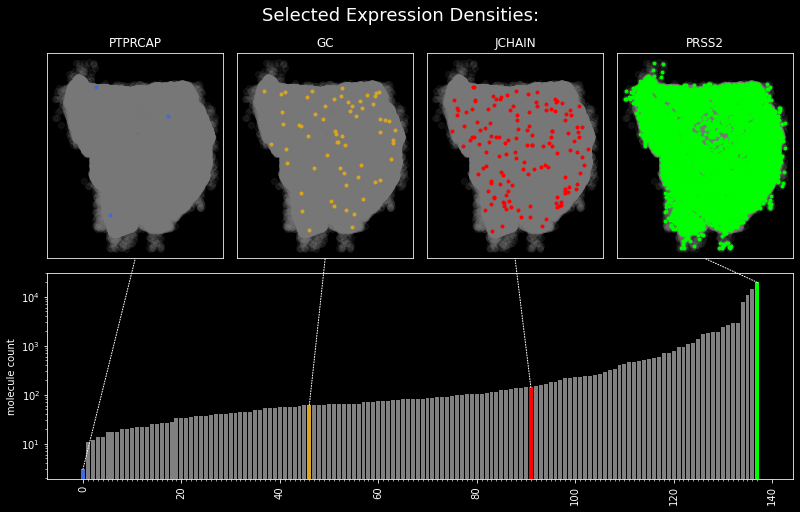

In [55]:
sdata.plot_overview()

<IPython.core.display.Javascript object>


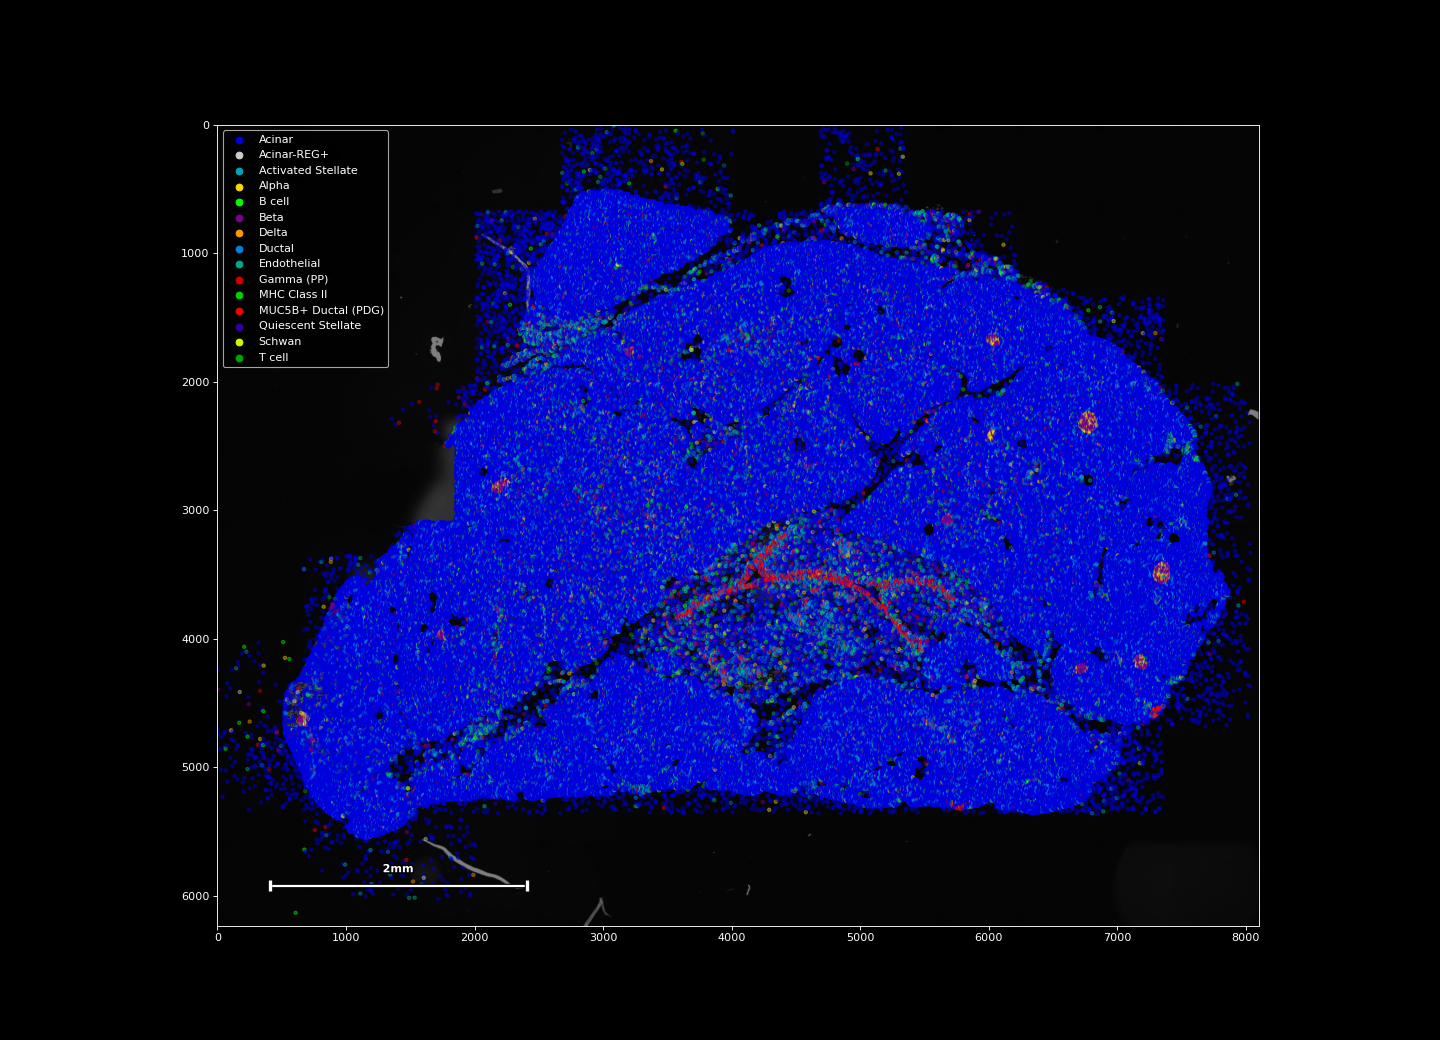

(<matplotlib.collections.PathCollection at 0x7fd1650a4b50>,
 None,
 <matplotlib.legend.Legend at 0x7fd1650f8b50>)

In [30]:
plt.figure(figsize=(18,13))
sdata.scatter(alpha=0.4,marker='.',legend=True,color_prop='celltype')

In [ ]:
knn_neighbors=120
bandwidth=18
n_neighbors=30
metric='euclidean'
min_dist=0.1
random_state=42
zero_weight=2

_=sdata.graph.update_knn(n_neighbors=knn_neighbors)

sdata.graph.run_umap(bandwidth=bandwidth,n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state,zero_weight=zero_weight)


In [22]:
sdata=pl.load('tosti.pl')



Index(['g', 'x', 'y', 'gene_id', 'noise'], dtype='object')


<IPython.core.display.Javascript object>


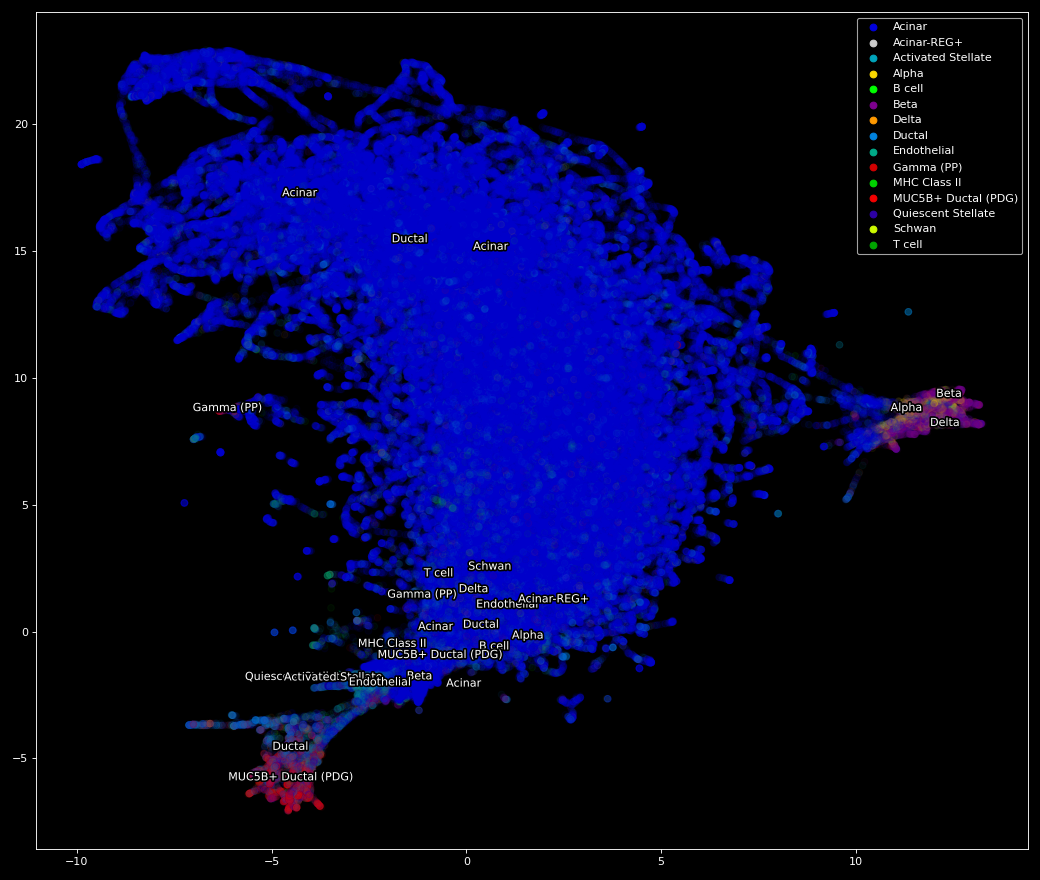

In [32]:
plt.figure(figsize=(13,11))
# sdata.scatter(color_prop='celltype',marker='x')
sdata.graph.plot_umap(color_prop='celltype',text_prop='celltype',alpha=0.05,thlds_text=[0.1,0.06,0.6],text_distance=0.9,legend=True)
plt.tight_layout()

In [27]:
sdata.save('tosti.pl')

<IPython.core.display.Javascript object>


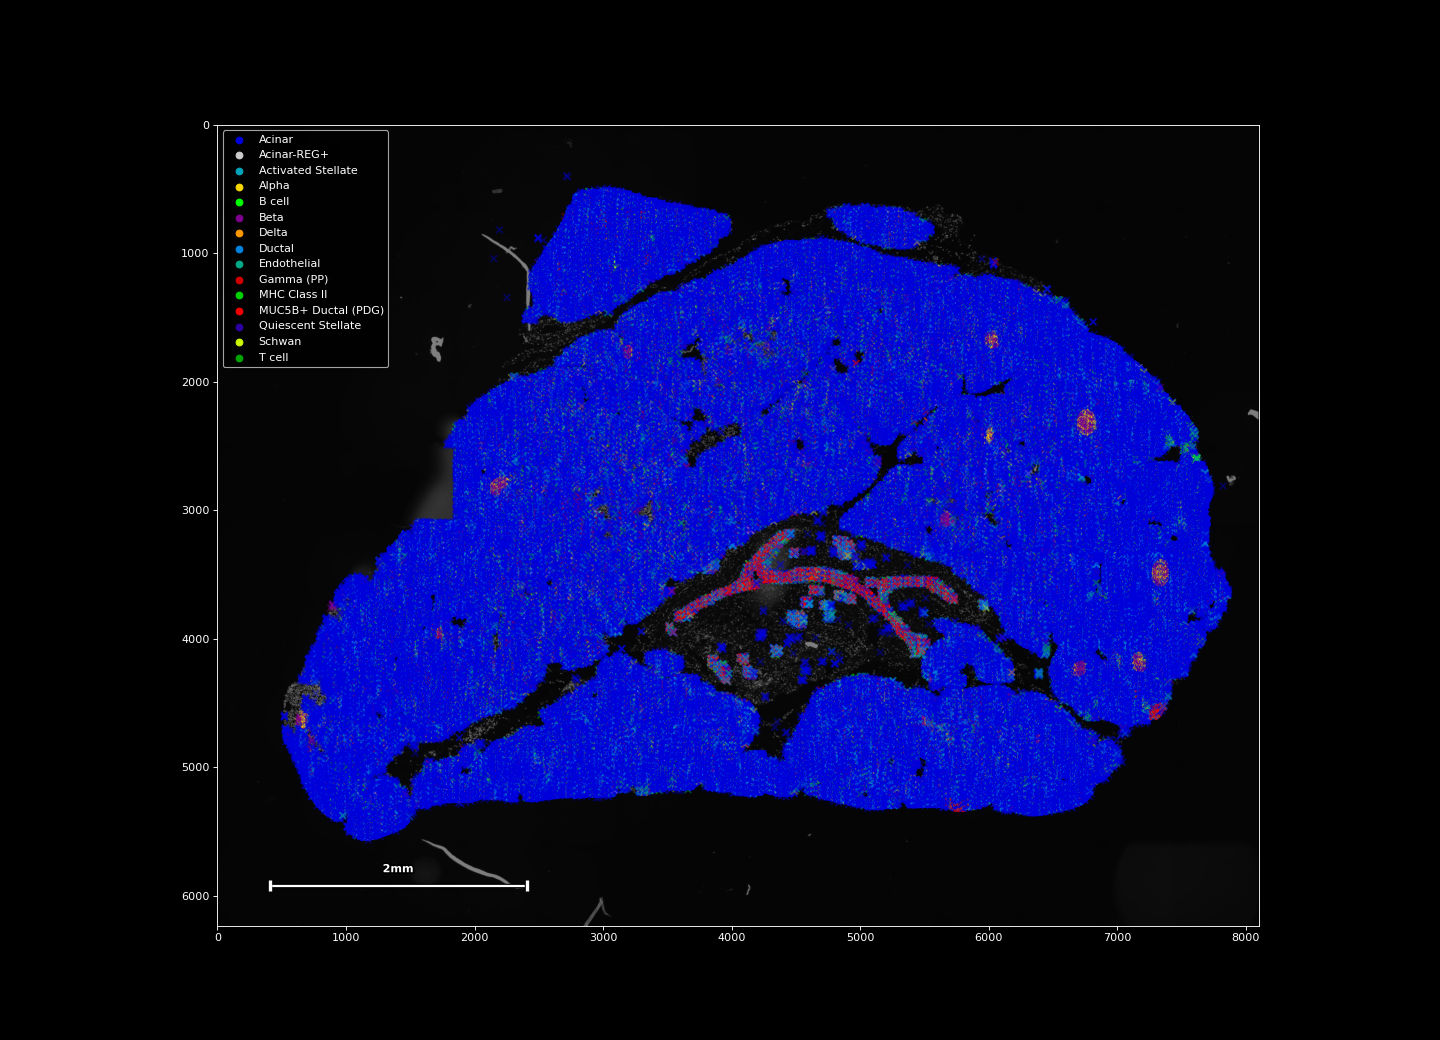

(<matplotlib.collections.PathCollection at 0x7fd1addd66a0>,
 None,
 <matplotlib.legend.Legend at 0x7fd1adc48a60>)

In [29]:
plt.figure(figsize=(18,13))
sdata[~sdata.noise].scatter(alpha=0.4,marker='x',legend=True,color_prop='celltype')

In [58]:
sdata.graph.umap_js()

    'data': [{'dx': 1.3402882340288236,
              'dy': 1.340…

In [23]:
tissues = sdata.noise.astype('category').replace(True,'noise').replace(False,'exocrine')
tissues=tissues.cat.add_categories(['islet','duct'])
tissues[sdata.islet]='islet'
tissues[sdata.duct]='duct'

AttributeError: 'SpatialData' object has no attribute 'islet'

In [24]:
sdata

g           x           y  gene_id  noise
0       PRSS1     2.01670  4241.44840       94   True
1        IAPP     2.63310  4394.34575       55   True
2       PRSS1    71.23775  4448.01275       94   True
3       PRSS1    76.12540  4346.39385       94   True
4       PRSS2    98.44645  4385.12990       95   True
...       ...         ...         ...      ...    ...
461073  PRSS1  8018.78445  4606.84630       94   True
461074  PRSS2  8021.01890  4358.93290       95   True
461075  PRSS2  8022.91500  4077.35870       95   True
461076  REG1A  8023.28350  4289.00500       99   True
461077  PRSS2  8038.43555  4370.85555       95   True

[461078 rows x 5 columns]

In [63]:
sdata['tissue']=tissues

(<matplotlib.collections.PathCollection at 0x7fb61d220a60>, None, None)

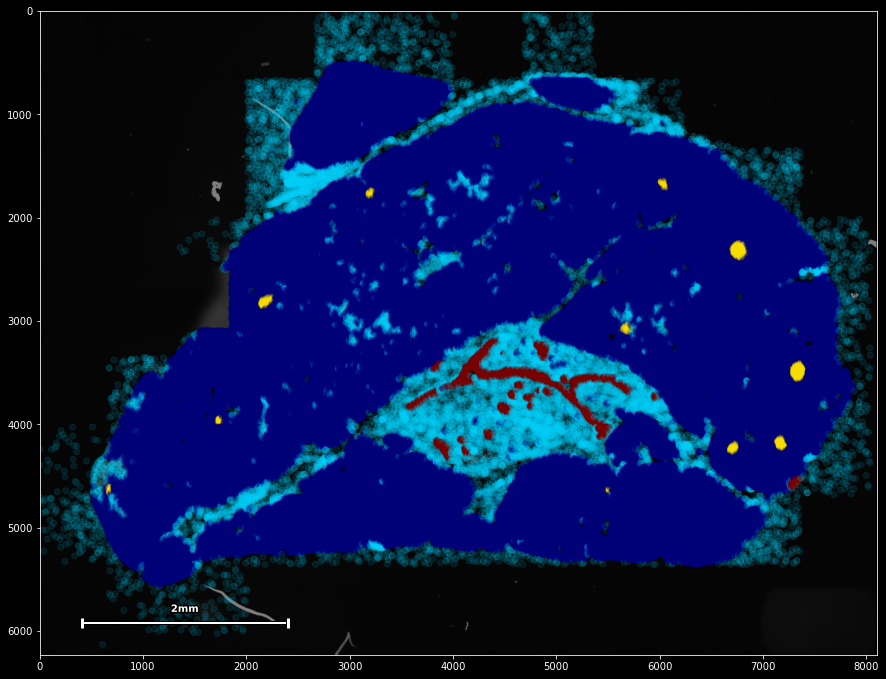

In [65]:
plt.figure(figsize=(15,15))
sdata.scatter(c=sdata.tissue.cat.codes,alpha=0.1)

In [13]:
from time import perf_counter

t1= perf_counter()
radii,cooc=sdata[sdata.g.isin(sdata.genes[(sdata.counts>100)])].stats.co_occurrence(max_radius=2000)

print(perf_counter()-t1)

1040.8533432519998


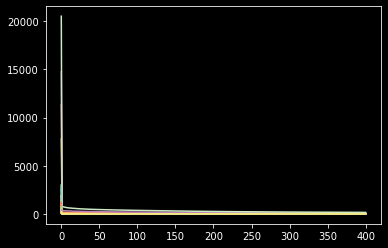

In [14]:
plt.plot(radii,cooc.diagonal())

In [49]:
sdata['celltype']=pd.Categorical(sdata.obsc.celltype[sdata.gene_ids])


In [51]:
radii,cooc=sdata.stats.co_occurrence(max_radius=2000,category='celltype')


15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


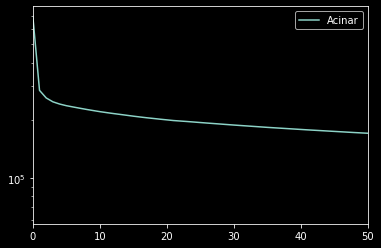

In [115]:
data_alpha = np.array([cooc[sdata.celltype.cat.categories=='Alpha',sdata.celltype.cat.categories=='Acinar'].squeeze(),
cooc[sdata.celltype.cat.categories=='Alpha',sdata.celltype.cat.categories=='Alpha'].squeeze(),
cooc[sdata.celltype.cat.categories=='Alpha',sdata.celltype.cat.categories=='Beta'].squeeze(),])

data_beta = data = np.array([cooc[sdata.celltype.cat.categories=='Beta',sdata.celltype.cat.categories=='Acinar'].squeeze(),
cooc[sdata.celltype.cat.categories=='Beta',sdata.celltype.cat.categories=='Alpha'].squeeze(),
cooc[sdata.celltype.cat.categories=='Beta',sdata.celltype.cat.categories=='Beta'].squeeze(),])

data_acinar = data = np.array([cooc[sdata.celltype.cat.categories=='Acinar',sdata.celltype.cat.categories=='Acinar'].squeeze(),
cooc[sdata.celltype.cat.categories=='Acinar',sdata.celltype.cat.categories=='Alpha'].squeeze(),
cooc[sdata.celltype.cat.categories=='Acinar',sdata.celltype.cat.categories=='Beta'].squeeze(),])


# data=data/data.sum(0)
# data=np.divide(data,np.sum(data,0))

handlers=plt.plot(radii,(data_acinar).T[:,0])
plt.yscale('log')
plt.xlim(0,50)
plt.legend(handlers,['Acinar','Alpha','Beta'],)



In [96]:
handlers

[[<matplotlib.lines.Line2D at 0x7f6e0fbcc4f0>,